In [1]:
import numpy as np
import matplotlib.pyplot as plt

# INF 554 Lab 3: Supervised Classification

In this lab we will perform the task of binary classification, i.e., we will be working with a dataset, in which each datapoint belongs to one of two classes. There is data provided in the *data/* folder. Suppose that each column represents an exam score during a course, with the class label indicated *admitted* or not into a Masters program at some university. We want a model to give the probability that a student will be admitted based on the two grades of two courses.  We begin by loading and inspecting the data.

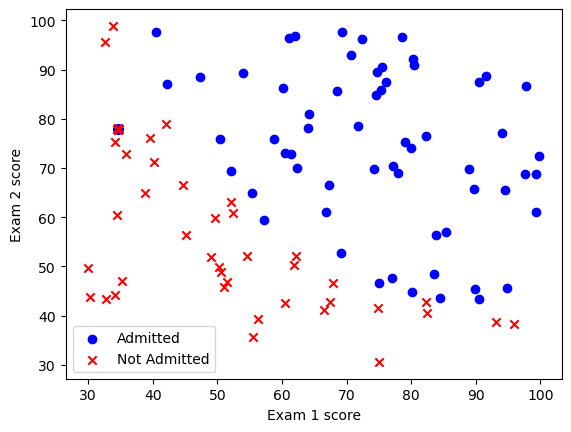

In [2]:
# Load the dataset
data = np.loadtxt('./data/data.csv', delimiter=',')
 
#Add intercept term 
data_1 = np.ones((data.shape[0], 4))
data_1[:, 1:] = data

X = data_1[:, 0:3]
y = data_1[:, -1]
y = y.reshape(-1, 1)

# Plot data 
pos = np.where(y == 1) # instances of class 1
neg = np.where(y == 0) # instances of class 0
plt.scatter(X[pos, 1], X[pos, 2], marker='o', c='b', label='Admitted')
plt.scatter(X[neg, 1], X[neg, 2], marker='x', c='r', label="Not Admitted")
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.show()


N = X.shape[0]



## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

<div class="alert alert-block alert-info">
Note: in this lab we are going to use $\mathbf{\theta}$ to denote the parameters, instead of $\mathbf{\beta}$ as we introduced in the first lab</div>

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

> **Task 1**: Implement the sigmoid function (1). Note that we want the sigmoid function to act elementwise on an input vector. Furthermore, note that the sigmoid function in NumPy is prone to overflow errors therefore to avoid them you will have to use the <a href="https://numpy.org/doc/stable/reference/generated/numpy.clip.html">clip</a> function to restrain the input $z$ of the function within the interval $[-10 ,10]$.


In [3]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """The sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        The array on which to elementwise compute the sigmoid function

    Returns
    -------
    np.ndarray
        The sigmoid value (1 / (1 + exp(-z)))
    """
    # insert here the code for Task 1
    return 1./(1.+np.exp(-np.clip(z, -10, 10)))


#Testing the sigmoid() function:
z = np.array([-1000, 0, 1000])
print('The obtained sigmoid values are:', sigmoid(z))

The obtained sigmoid values are: [4.53978687e-05 5.00000000e-01 9.99954602e-01]


In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

> **Task 2**: Implement the negative log likelihood, or cost function.

In [4]:
def cost(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    """Computes the cost using theta as the parameters for logistic regression.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    float
        The sum of the cost for each sample
    """
    # insert here your implementation
    return - np.sum(y * np.log(sigmoid(X@theta)) + (1-y) * np.log(1-sigmoid(X@theta)))


#Testing the cost() function:
theta_testing = np.array([1, 0, 0])
X_testing = np.array([[-1000,0,0],[1000,0,0]]) 
y_testing = np.array([0, 1])
print('The calculared cost on this toy dataset is:', cost(theta_testing, X_testing, y_testing))

The calculared cost on this toy dataset is: 9.079779843364126e-05


As in OLS of the previous lab we want to find values of the parameters which minimize our cost function. 

>**Ques 1**:Derive the gradient of the cost function with respect to the model's parameters $\nabla_{\mathbf{\theta}} E(\mathbf{\theta})$.

<div class="alert alert-block alert-info">
Some hints:
    
- you can use the expression of a Bernoulli distribution, $\sigma_i^{y_i} (1-\sigma_i)^{1-y_i}$ where $\sigma_i \equiv \sigma(\mathbf{\theta}^\top\mathbf{x}_i)$. 

- A useful derivative: $\sigma' = (1 - \sigma)\sigma$.</div>

You'll notice that, unlike under OLS, it's not a closed form expression; you have $\mathbf{\theta}$ on the right hand side of the equation. Nevertheless, we can use numerical methods to find the optimal ${\mathbf{\theta}^*}$.

>**Task 3**: Implement the gradient of the cost function (which you just derived above).


In [5]:
def compute_grad(theta: np.ndarray, X:np.ndarray, y:np.ndarray) -> np.ndarray:
    """Computes the gradient of the cost with respect to the parameters.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    np.ndarray
        The gradient, of shape (n_features,)
    """
    # Insert your code here

    return X.T @ (sigmoid(X@theta)- y)

#Testing the compute_grad() function:
theta_testing = np.array([-1, 0, 0])
X_testing = np.array([[-1000, 0, 0],[1000, 0, 0]]) 
y_testing = np.array([0, 1])
print('The gradient that we obtain is:', compute_grad(theta_testing, X_testing, y_testing))

The gradient that we obtain is: [-1999.90920426     0.             0.        ]


What we have now is a vector $\mathbf{g} = \nabla_{\mathbf{\theta}} E(\mathbf{\theta})$; the **gradient** of the cost function. Note that the dimensionality is the same as the input. We can move in the direction of the gradient and thus descend the cost function. This is the idea of **Gradient Descent**: we iteratively follow the gradient down the error surface. We repeatedly carry out 
\begin{equation}
\mathbf{\theta}_{t+1} = \mathbf{\theta}_{t} - \alpha \nabla_{\mathbf{\theta}} E(\mathbf{\theta}_t) \hspace{1.5cm}(4)
\end{equation}

where $\alpha$ is the **learning rate**; for $t=1,2,\ldots,T$, such that $\mathbf{\theta}^* \gets \mathbf{\theta}_T$.


Now all that remains to do is to find the optimal parameters using gradient descent. In the following we make a train-test split of the data provided, keeping the last 20 data points as test set away, and the first 80 as train. (*Note: If we apply the terminology that we introduced in the first lab, we actually carry out validation; but since we don't define a proper test set in this case, we can call the validation set "test set"*).



 
> **Task 4**: Please complete following sub-tasks. 
>1) Use the functions implemented so far to implement gradient descent, Eq.(4), for a fixed number of steps (say, $T=1\,000$) and three different learning rates: $\alpha \in \{0.5, 0.05, 0.005\}$.
>2) Evaluate the classifier (similarly to what was done in the first lab): plot the error $E(\mathbf{\theta}_t)$ both on the training and test set, for $t=1, 10, 20, 30, \ldots,T$ (make sure to divide both the error $E(\mathbf{\theta}_t)$ recorded on the training and test set by the number of data points they contain such that the two errors are on the same scale and can reasonably be compared). 


The fitted parameters for alpha=0.500 are: [3.314, 10.743, 6.033]
The fitted parameters for alpha=0.050 are: [0.744, 4.102, 3.789]
The fitted parameters for alpha=0.005 are: [0.722, 3.987, 3.685]


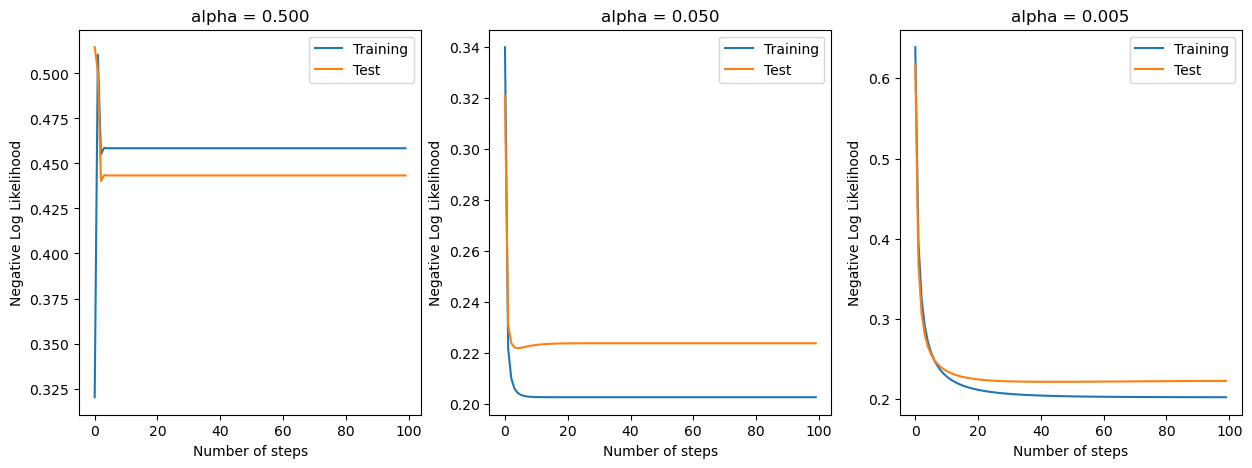

In [6]:
np.random.seed(0)            

n_test=20

X_train = X[:-n_test,:]
y_train = y[:-n_test,:]

X_test = X[-n_test:,:]
y_test = y[-n_test:,:]

# Standardize train and test (as in lab1 we use mean and st.dev from training to standardize test)
# We do not standardize column 0 because it is the intercept term containing only "1" values
m = np.mean(X_train[:,1:],axis=0)
s = np.std(X_train[:,1:],axis=0)
X_train[:,1:] = (X_train[:,1:] - m) / s
X_test[:,1:] = (X_test[:,1:] - m) / s

T = 1000
fig, axs = plt.subplots(1,3, figsize=(15,5))  

alphas = [0.5, 0.05, 0.005]
thetas = []

for idx_col, alpha in enumerate(alphas):
    training_likelihood = []
    test_likelihood = []
    
    theta = np.random.randn(3,1) * 0.05

    for i in range(T): 
        # insert here your code
        theta = theta - alpha * compute_grad(theta, X_train, y_train)

        if i%10==0:
            training_likelihood.append(cost(theta, X_train, y_train)/len(y_train))
            test_likelihood.append(cost(theta, X_test, y_test)/len(y_test))

    print(f'The fitted parameters for alpha={alpha:.3f} are: [{theta[0].item():.3f}, {theta[1].item():.3f}, {theta[2].item():.3f}]')
    thetas.append(theta)
 
    # Plot
    ax = axs[idx_col]
    ax.plot(np.arange(int(T/10)), training_likelihood)
    ax.plot(np.arange(int(T/10)), test_likelihood)
    ax.legend(['Training', 'Test'])
    ax.set_title("alpha = %1.3f" % alpha)
    ax.set_ylabel('Negative Log Likelihood')
    ax.set_xlabel('Number of steps')

> **Question 2**: Compare the log-likelihood plots. What conclusions can you draw regarding the learning rate and the performance of the model? Knowing that the cost function is convex, are you convinced that with a suitable learning rate, gradient descent will always converge to the minimum?

> **Task 5**: Implement a function to provide predictions $\hat{\mathbf{y}} \in \{0,1\}$ for any given $\mathbf{x}$ and $\hat{\mathbf{\theta}}$ (from Task 4) by assigning $\hat{\mathbf{y}}_i = 1$ whenever $\sigma_i \geq 0.5$. In other words, you turn logistic regression into a **classifier**. 

In [7]:
def predict(theta: np.ndarray, X:np.ndarray, threshold:float=.5) -> np.ndarray:
    """Predict whether each label is 0 or 1 using learned logistic regression parameters theta.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    threshold : float
        The threshold to split predictions with label 0 and 1

    Returns
    -------
    np.ndarray
        The predictions, of shape (n_sample,)
    """
    # Insert here your code
    return 1*(sigmoid(X@theta)>=threshold)


#Let's take a look at the final accuracy
for theta, alpha in zip(thetas, alphas):
    accuracy_train = 1 - np.mean(np.abs(predict(theta,X_train)-y_train))
    accuracy_test = 1 - np.mean(np.abs(predict(theta,X_test)-y_test))
    print(f"\nEvaluation for alpha:{alpha:.3f}")
    print(f"theta: [{theta[0].item():.3f}, {theta[1].item():.3f}, {theta[2].item():.3f}]")
    print(f"Accuracy on training set: {accuracy_train:.3f}")
    print(f"Accuracy on testing set : {accuracy_test:.3f}")


Evaluation for alpha:0.500
theta: [3.314, 10.743, 6.033]
Accuracy on training set: 0.912
Accuracy on testing set : 0.850

Evaluation for alpha:0.050
theta: [0.744, 4.102, 3.789]
Accuracy on training set: 0.887
Accuracy on testing set : 0.900

Evaluation for alpha:0.005
theta: [0.722, 3.987, 3.685]
Accuracy on training set: 0.887
Accuracy on testing set : 0.900


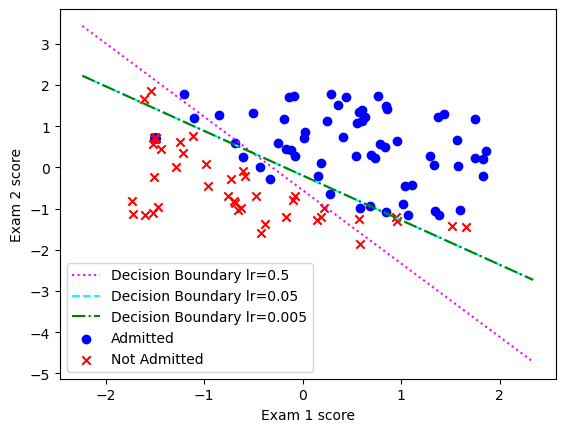

In [8]:
# Let's plot the learned decision boundary
plt.figure()
plot_x = np.array([min(X[:, 1])-0.5, max(X[:, 2])+0.5])
cols, lst = ['magenta', 'cyan', 'green'], [":", "--", "-."]
for i, (theta, alpha) in enumerate(zip(thetas, alphas)):
    plot_y = (- 1.0 / theta[2,0]) * (theta[1,0] * plot_x + theta[0,0])
    plt.plot(plot_x, plot_y, c=cols[i], label=f'Decision Boundary lr={alpha}', linestyle=lst[i])
plt.scatter(X[pos, 1], X[pos, 2], marker='o', c='b', label='Admitted')
plt.scatter(X[neg, 1], X[neg, 2], marker='x', c='r', label="Not Admitted")
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.show()

> **Question 3**:  Compare qualitatively the decision boundaries obtained for the parameters learned with the three different learning rates.

We will now implement a variant of gradient descent, that is widely used in Deep Learning nowadays. This variant is called stochastic gradient descent (sgd). In sgd we use random subsets, called _batches_, of the training set to estimate the gradient and take a step for each estimated gradient instead of working with exact gradients calculated over the whole dataset. The hyperparameters of sgd are the batch size, i.e., the number of data points in each batch, and the learning rate $\alpha.$

In particular, we begin by randomly permuting the indices $\{1,\ldots, n\}.$ We use the permuted index set to define batches of randomly sampled data points, where each batch has the specified batch size. For example, for a batch size of 10, the first 10 indices of our randomly permuted array would specify the datapoints that are in the first batch of data points. 


We then compute the gradient of the cost function for the data points in the first batch and take a step in the direction of this gradient, where the magnitude of the step is determined by the learning rate $\alpha.$ We proceed similarly for all subsequent batches in our training set. 

Once sgd has looped through all batches in the dataset, we say one _epoch_ of training was completed.


> **Task 6**: Please implement stochastic gradient descent as described above and then use it to fit the logistic regression classifier to our dataset.

Our fitted parameters are: [0.743, 4.073, 3.812]


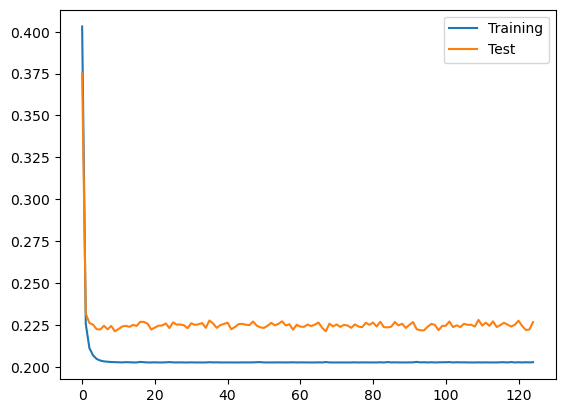

In [9]:
training_likelihood = []
test_likelihood = []

def sgd(n_iterations: int, batch_size: int, alpha: float, X:np.ndarray, y: np.ndarray) -> np.ndarray:
    """Trains the logistic regression using Stochastic Gradient Descent (SGD).
    
    Parameters
    ----------
    n_iterations : int
        The number of iteration of the SGD algorithm.
    batch_size : int
        The number of element per batch to compute the gradient.
    alpha : float
        The learning rate
    X : np.ndarray
        The training points, of shape (n_sample, n_features)
    y : np.ndarray
        The training labels, of shape (n_sample, 1)

    Returns
    -------
    np.ndarray
        The final parameters of the logistic regression, of shape (n_features,)
    """
    # insert your code here
    epochs = int(n_iterations/(len(y)/batch_size))
    theta = np.random.randn(3,1) * 0.05
    
    for i in range(epochs):
        idx = np.random.permutation(X.shape[0])
        for batch_index in range(int(X.shape[0]/batch_size)):
            current_batch = idx[batch_index*batch_size:(batch_index+1)*batch_size]
            theta = theta - alpha * compute_grad(theta, X[current_batch, :], y[current_batch])
    
        if i%10==0:
            training_likelihood.append(cost(theta, X_train, y_train)/len(y_train))
            test_likelihood.append(cost(theta, X_test, y_test)/len(y_test))
            
    return theta

np.random.seed(0)            
alpha = 0.05
theta = sgd(10000, 10, alpha, X_train, y_train)
print(f'Our fitted parameters are: [{theta[0].item():.3f}, {theta[1].item():.3f}, {theta[2].item():.3f}]')

plt.figure()
plt.plot(np.arange(125), training_likelihood)
plt.plot(np.arange(125), test_likelihood)
plt.legend(['Training', 'Test'])
plt.show()

> **Question 4**: What are the advantages of stochastic gradient descent over classical gradient descent? (Especially with a non-convex loss function).

## K-Nearest Neighbours

The method $k$NN takes a different approach to modeling $P(Y=1|\mathbf{x})$. It is a *non-parametric* **lazy** method, and does not have a "model" as such. It predicts with
$$
P(Y=1|\mathbf{x}) \approx \frac{1}{k} \sum_{\mathbf{x}_i \in \textsf{N}_k(\mathbf{x})} y_i 
$$
where $\textsf{N}_k(\mathbf{x})$ is the *neighbourhood* of the $k$ training examples closest to $\mathbf{x}$ (typically measured by Euclidean distance). 

> **Question 5**: What is the effect of different values of $k$? Hint: Draw on paper and/or empirically test different values.

> **Question 6**: What is the complexity of making a prediction with a naive implementation of $k$-NN? When is this likely to be a problem in practice?

> **Task 7**: Implement this function to create a $k$-NN classifier and evaluate it on the data provided. Hint: there is not really any training stage here; simply store the training instances to search over later.

In [10]:
from numpy.linalg import norm

def kNN(k: int, X: np.ndarray, y: np.ndarray, x: np.ndarray) -> int:
    """kNN classification of x
    
    Parameters
    ----------
    k : int
        The number of neighbors to consider
    X : np.ndarray
        The training points to search the neighbors, of shape (n_sample, n_features)
    y : np.ndarray
        The training labels to search the neighbors, of shape (n_sample, 1)
    x : np.ndarray
        A testing instance, of shape (1, n_features)

    Returns
    -------
    int
        The label of the testing instance
    """

    # Enter here your solution for Task 9
    # Hint: you may use the function 'norm'
    
    #O(nd)
    distances = norm(X-x, axis=1)
    
    #O(n log(n)) #Could be O(nk) if we selected the smallest distance k times
    idx = distances.argsort()
    
    labels = y[idx]
    
    #neglegible O(kc) (need to count c elements in a list of length k)
    classes, counts = np.unique(labels[:k], return_counts=True)
    
    classification = np.argmax(counts)
    return classes[classification]
    

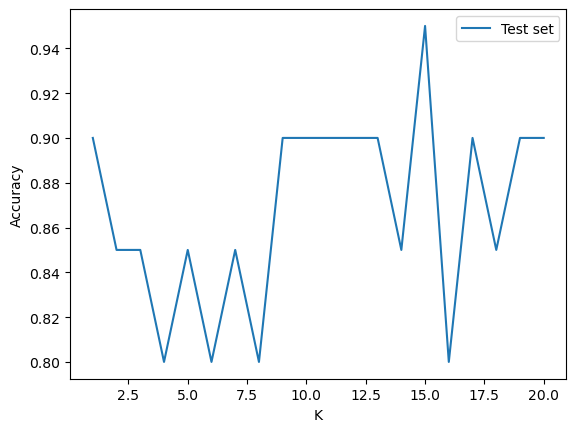

In [11]:
# Test the kNN method for various k
Kmax=20
knn_accuracy = []

for k in range(1, Kmax+1):
    y_pred = np.zeros(len(y_test))

    for i in range(len(y_pred)):
        y_pred[i] = kNN(k, X_train, y, X_test[i,:])

    knn_accuracy.append(1-np.mean(np.abs(y_pred.reshape(-1,1)-y_test)))
        
plt.plot(np.arange(1,Kmax+1), knn_accuracy, label='Test set')
plt.legend()
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()